<h1><center>XOR Project</center><h1>

### Introduction
- This project aims to solve the classical XOR problem by using the machine learning based methods with Pytorch.

### Problem Definition
- Dataset: 200 training examples, 100 validation examples, 100 test examples
- Each example contains 2 features drawn from the unifrom distribution between [-1, 1)
- The label is 0 if the product between 2 features is smaller than 0 else 1

### 1. Dataset

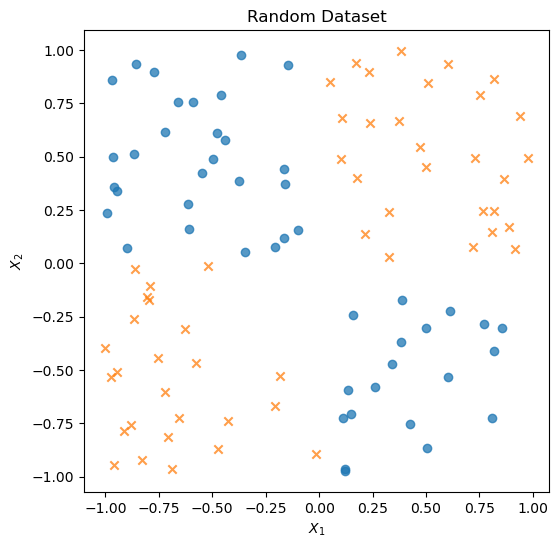

torch.Size([16, 2])
torch.Size([16, 2])
torch.Size([16, 2])
torch.Size([16, 2])
torch.Size([16, 2])
torch.Size([16, 2])
torch.Size([4, 2])


In [6]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from torch.utils.data import DataLoader, TensorDataset

# Train Dataset: 1, Validation Dataset: 2, Test Dataset: 3

def generateDataLoader(size:int, batchSize:int, featureNumber:int, seed:int) -> DataLoader:
    '''
        By default, all dataloader uses shuffling for better performance
    '''
    dataset, label = generateNumpyDataset(size, featureNumber, seed)
    dataset, label = torch.tensor(dataset, dtype=torch.float32), torch.tensor(label, dtype=torch.float32)

    tensorDataset = TensorDataset(dataset, label)

    return DataLoader(tensorDataset, batchSize, shuffle=True)

def generateNumpyDataset(size:int, featureNumber:int, seed:int) -> tuple[np.ndarray, np.ndarray]:
    '''
        Return a dataset that is sampled from the uniform distribution bewteen -1 and 1
    '''
    np.random.seed(seed)

    data = np.random.uniform(-1, 1, (size, featureNumber))
    label = np.ones(size)
    label[data[:,0]*data[:,1] < 0] = 0

    return data, label

def plotNumpyDataset(data:np.ndarray, label:np.ndarray, title:str):
    '''
        Plot the dataset using different symbols for different classes
    '''
    figure = plt.figure(figsize=(6,6))

    plt.scatter(data[label==0, 0], data[label==0, 1], marker="o", alpha=0.75)
    plt.scatter(data[label==1, 0], data[label==1, 1], marker="x", alpha=0.75)

    plt.xlabel(r"$X_1$")
    plt.ylabel(r"$X_2$")
    plt.title(title)

    plt.show()

data, label = generateNumpyDataset(100, 2, 1)
plotNumpyDataset(data, label, "Random Dataset")

### 2. Pytorch Model
- The model is consisted of 3 linear layers (with ReLU activation function) + the final Sigmoid layer as output layer
- A small zero-mean Gaussian noise is added at the first layer to regularise the model and avoid the overfitting problem only during the training process

In [ ]:
import torch

from torch import nn

class NoisyLinear(nn.Module):
    '''
        Customized initialisation + noise during the training
    '''
    def __init__(self, inputFeature:int, outputFeature:int, noiseSTD:float):
        super().__init__()

        self.weight = nn.Parameter(self.constructWeight(inputFeature, outputFeature))
        self.offset = nn.Parameter(self.constructOffset(outputFeature))
        self.noiseSTD = noiseSTD
    
    def forward(self, input:torch.Tensor, training:bool=False) -> torch.Tensor:
        '''
            Only add a random zero-mean Gaussain noise to the input during the training process
        '''
        if training:
            noise = torch.normal(0, self.noiseSTD, input.shape)
            input = torch.add(input, noise)
        
        return torch.add(torch.mm(input, self.weight), self.offset)
    
    def constructWeight(self, inputFeature:int, outputFeature:int) -> torch.Tensor:
        '''
            By default, the weight of the layer is initialised by xavier uniform
        '''
        weight = torch.Tensor(inputFeature, outputFeature)
        nn.init.xavier_uniform_(weight)

        return weight
    
    def constructOffset(self, outputFeature:int) -> torch.Tensor:
        '''
            By default, the offset of the layer is initilised by filling 0
        '''
        offset = torch.Tensor(outputFeature).fill_(0)

        return offset

In [8]:
import torch

from torch import nn

class NoisyModel(nn.Module):
    '''
        3 (Linear + ReLU) + Sigmoid
    '''
    def __init__(self, inputFeature:int, outputFeature:int, noiseSTD:float):
        super(NoisyModel, self).__init__()

        self.noisyLayer = NoisyLinear(inputFeature, inputFeature*2, noiseSTD)
        self.layer = nn.Sequential(
            nn.ReLU(),
            nn.Linear(inputFeature*2, inputFeature*2),
            nn.ReLU(),
            nn.Linear(inputFeature*2, outputFeature),
            nn.Sigmoid()
        )
    
    def forward(self, input:torch.Tensor, training:bool=False) -> torch.Tensor:
        result = self.noisyLayer(input, training)
        result = self.layer(result)

        return result.flatten()
    
    def predict(self, input:np.ndarray) -> torch.Tensor:
        input = torch.from_numpy(input).float()
        result = self.forward(input)

        return (result >= 0.5 ).float()

### 3. Experiment
- Epoch: 200
- Batch Size: 2, the size of the dataset is too small => requires a small batch size for more gradient calculation and update
- Learning Rate: 1e-3, try a small learning rate first to work with a small batch size
- Optimizer: Adam, auto adapted learning rate for better training process
- Loss: Binary Cross Entropy Loss, very suitable for 2-class classification problems

In [ ]:
import torch

from torch import nn
from torch.optim import Adam

def trainBatch(trainDataBatch:torch.Tensor, trainLabelBatch:torch.Tensor, model:NoisyModel, optimiser:Adam, loss:nn.BCELoss) -> tuple[float, float]:
    '''
        Train the model using the given batch data and return the batch loss/accuracy
    '''
    prediction = model.forward(trainDataBatch, True)

    optimiser.zero_grad()
    trainLossBatch = loss(prediction, trainLabelBatch)
    trainLossBatch.backward()
    optimiser.step()

